# Model Testing

Use this notebook to test a Mask R-CNN model. The weights to test can be loaded and testing will evaluate the mAP and mAR for the model.

Import the required libraries for loading the Mask R-CNN model and pruning it.


In [ ]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from skimage.morphology import label
from skimage.io import imread
from skimage.io import imshow
import time
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Due to memory limitations, limit the memory that can be used on the GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
ROOT_DIR = os.path.abspath("") # Setthe root directory of the project, where the notebook is running
DATA_DIR = os.path.join(ROOT_DIR, "datasets/airbus_data") # Set the location of the data
SHIP_CLASS_NAME = 'ship' # Declare the class name to be detected

# Set locations for training and testing data
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train_v2")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test_v2")
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(DATA_DIR, 'train_ship_segmentations_v2.csv')

Import the Mask R-CNN framework obtained from https://github.com/akTwelve/Mask_RCNN

In [ ]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
masks = pd.read_csv(TRAIN_SHIP_SEGMENTATIONS_PATH)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Define functions needed to produce the mask outputs

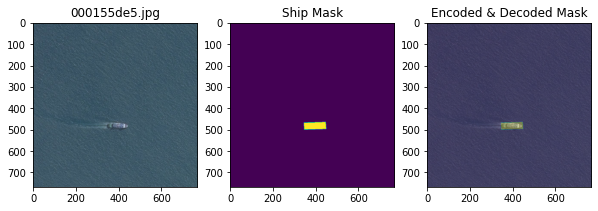

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


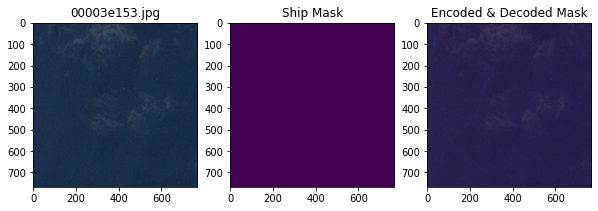

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0
It could be different when there is no mask.


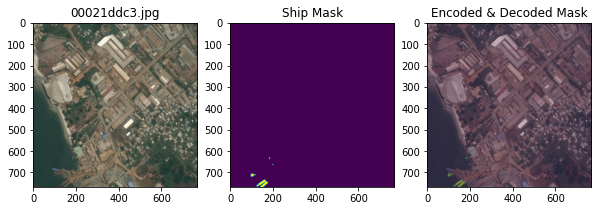

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
It could be different when there are masks overlapped.


In [ ]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
  
    pixels = img.T.flatten() 
  
    pixels = np.concatenate([[0], pixels, [0]])
 
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  
    runs[1::2] -= runs[::2]
   
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768,768)):

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=(768,768)):
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DATA_DIR):
   
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    rle_1 = masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
shows_decode_encode('00021ddc3.jpg')

Create a split for the validation data and exclude some corrupted images


In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(TRAIN_DATA_DIR) if f not in exclude_list]
test_names = [f for f in os.listdir(TEST_DATA_DIR) if f not in exclude_list]

print(len(train_names), len(test_names))

192555 15606


unique_img_ids groupby took: 3.759268283843994


,ImageId,ships,RleMaskList
132072,af9014590.jpg,4,[204885 1 205652 4 206420 5 207187 7 207954 7 ...
20137,1abd998f8.jpg,2,[404555 2 405321 4 406088 6 406856 6 407625 6 ...
110327,92af1c5c1.jpg,2,[483479 2 484245 4 485011 7 485777 9 486543 12...


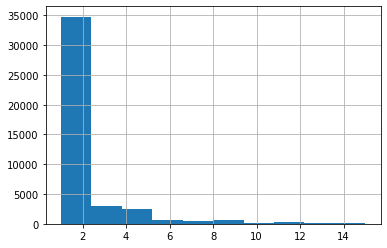

In [ ]:
masks['ships'] = masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

start_time = time.time()
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'})
unique_img_ids['RleMaskList'] = masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()
end_time = time.time() - start_time
print("unique_img_ids groupby took: {}".format(end_time))
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

34044 training masks
8512 validation masks


<AxesSubplot:>

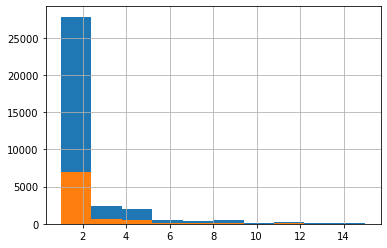

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(unique_img_ids, 
                 test_size = 0.2, 
                 stratify = unique_img_ids['ships'])
print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist()

Define a Dataset Class which holds the information related to the dataset as well as funcitons for loading it

In [ ]:
class ShipDetectionDataset(utils.Dataset):
    def __init__(self, image_dir, ids, masks, orig_height, orig_width):
        super().__init__(self)
        self.image_file_dir = image_dir
        self.ids = ids
        self.masks = masks
        self.image_width = orig_width
        self.image_height = orig_height

        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()

    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

Define the configuration class for the model

In [ ]:
class ShipDetectionConfig(Config):
    NAME = 'SHIPS'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BACKBONE = 'resnet50'
    
    IMAGE_RESIZE_MODE = "crop"

    NUM_CLASSES = 1+1
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05
    TRAIN_ROIS_PER_IMAGE = 24
    LEARNING_RATE = 1e-4
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 15

config = ShipDetectionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

Prepare the datasets

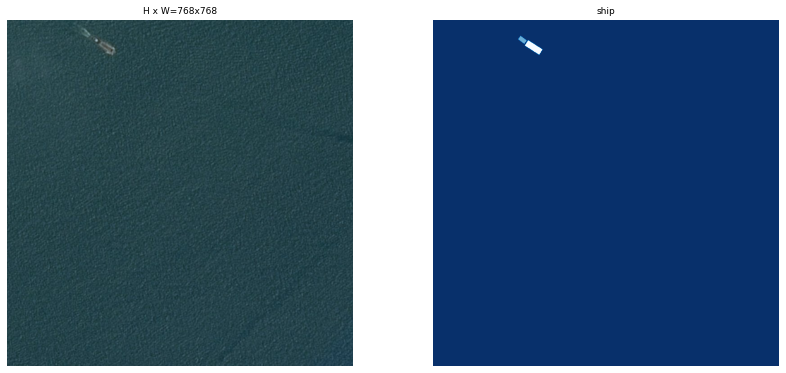

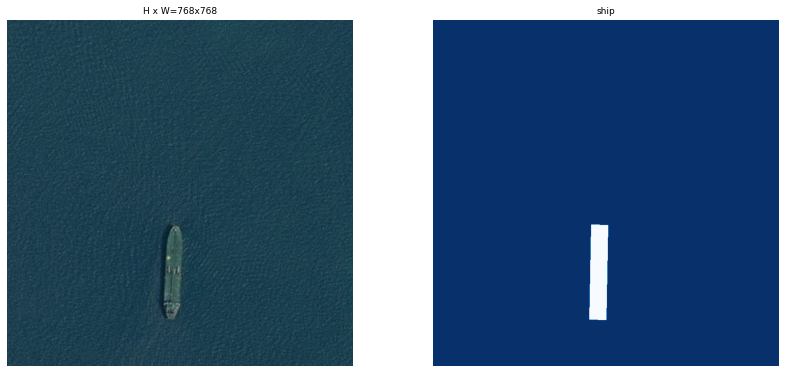

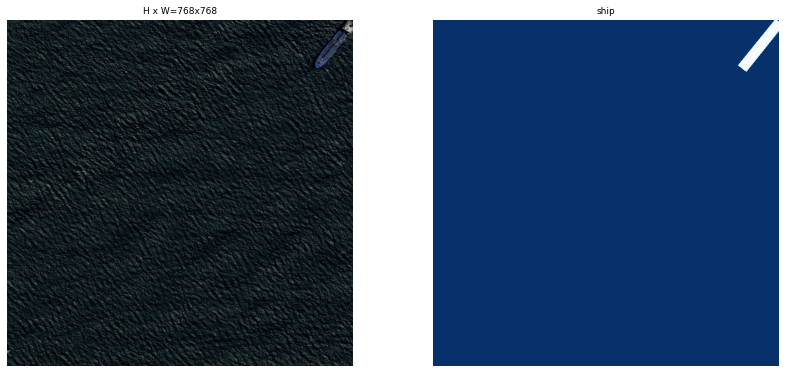

dataset prepare: 3.827382802963257


In [ ]:
start_time = time.time()
dataset_train = ShipDetectionDataset(image_dir=TRAIN_DATA_DIR, ids=train_ids, masks=masks, orig_height=768, orig_width=768)
dataset_train.prepare()
dataset_val = ShipDetectionDataset(image_dir=TRAIN_DATA_DIR, ids=val_ids, masks=masks, orig_height=768, orig_width=768)
dataset_val.prepare()

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

Change the value of model path to the value of your weights to be tested

In [ ]:
model_path = os.path.join(ROOT_DIR, 'ships20201030T1506/mask_rcnn_ships_0123.h5')

Convert the model to inference mode before loading the weights

In [ ]:
class InferenceConfig(ShipDetectionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/chris/Topics In Computer Science/Mask_RCNN/ships20201102T1440/mask_rcnn_ships_0080.h5
Re-starting from epoch 80


Display an output of the model detections

In [ ]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



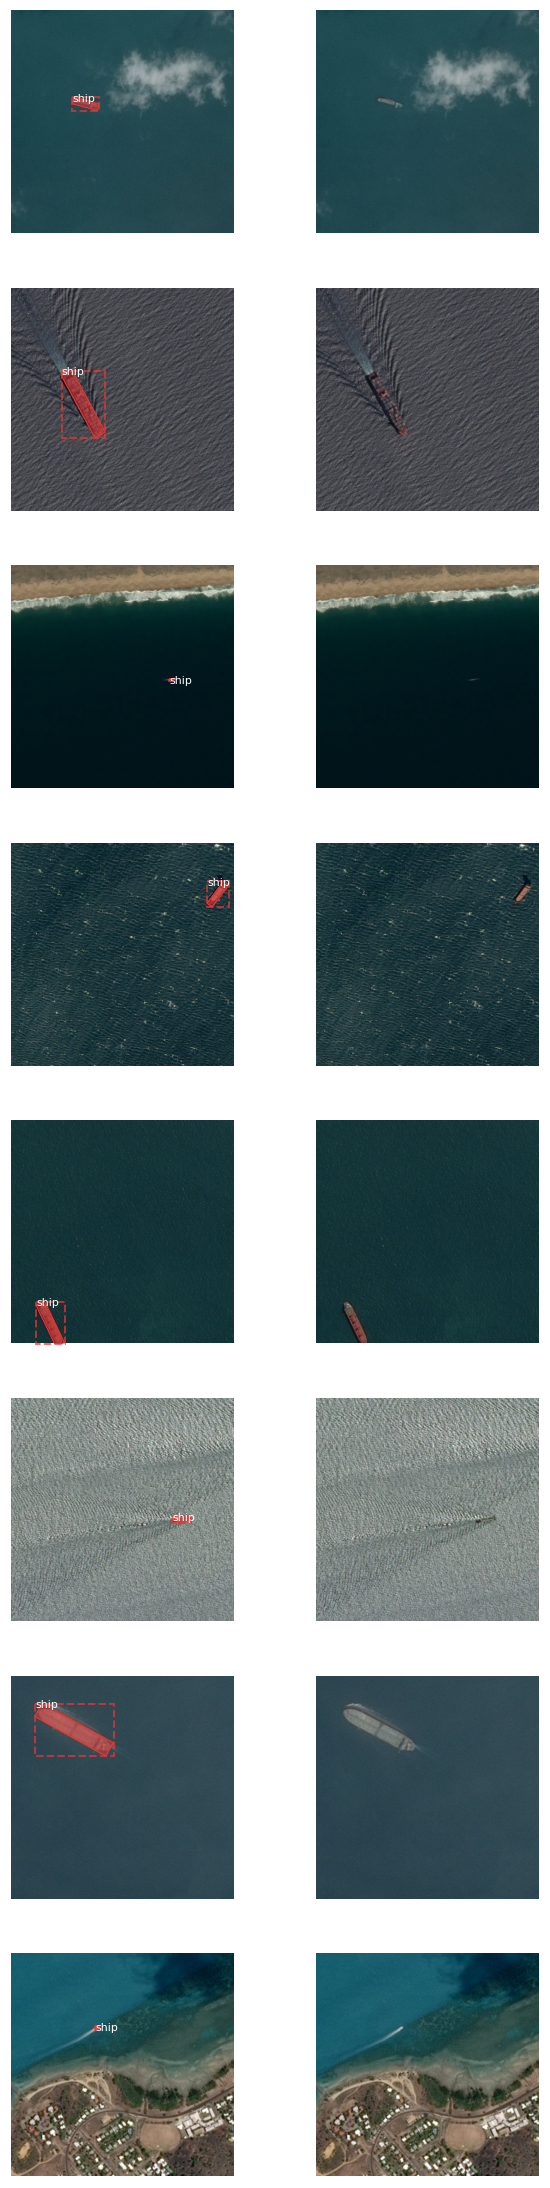

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

# Testing the model's mAP and mAR
Use a sample of images to calculate the mAP and mAR for the model.

Uncomment the visulaize.save_image line to save the images, change the parameters to choose a location to save them and more 

original_image           shape: (512, 512, 3)         min:    0.00000  max:  235.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 2535.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  187.00000  max:  421.00000  int32
gt_mask                  shape: (512, 512, 2)         min:    0.00000  max:    1.00000  bool


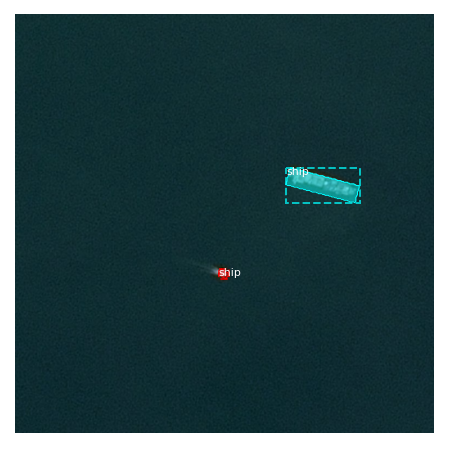

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  235.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  131.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32

*** No instances to display *** 



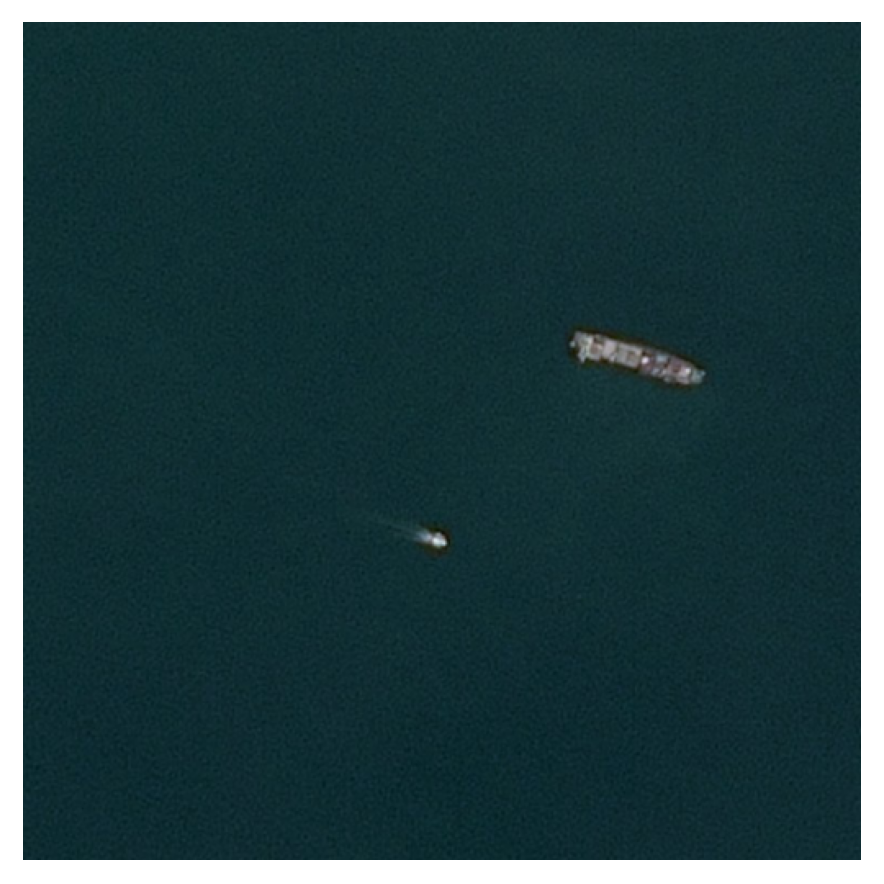

Inference Time: 0.21 Minutes
mAP:  0.03776190504431724
mAR:  0.022357142857142853


In [ ]:
image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 100)
#image_ids = dataset_val.image_ids;
APs = []
arecalls = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = model.detect([image], verbose=0)
    r = results[0]
    #visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'])
    #visualize.save_image(image, image_id, r['rois'], r['masks'], r['class_ids'], r['scores'], dataset_val.class_names, filter_classs_names=None,
    #           scores_thresh=0.1, save_dir='working', mode=0)

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    recall, _ = utils.compute_recall(r["rois"], gt_bbox, 0.5)
    #print(np.mean(recall))
    arecalls.append(np.mean(recall))

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))
print("mAR: ", np.mean(arecalls))